# MAP Logistic Regression, Dirichlet-multinomial Bayesian model, & Guassian Mixture Models

## Problem 1 - MAP for Logistic Regression

### iii) Implement objective on synthetic data

In [477]:
from scipy.optimize import minimize
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.style.use("ggplot")

Initial objective value -0.6335206602820121
Optimal Objective value -0.9515458191313326
Optimal coefficients [ 4.12173175 -3.74513246]


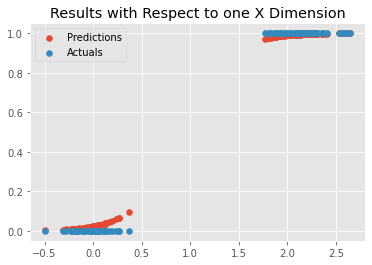

In [478]:
# create synthetic data
n_obs = 100
y = np.random.randint(0, 2, n_obs)
X_dims = [1, n_obs]
expected_coef = np.random.normal(loc=0, scale=1, size=5)
X = [np.add(y*expected_coef[dim], np.random.normal(loc=0, scale=.2, size=len(y))) 
     for dim in range(X_dims[0])]
X.append([1]*X_dims[1])
X = np.array(X)

# define initial thetas
theta_init = np.array([1]*X.shape[0])

# MLE for parameters theta
def objective(theta, y, X, _lambda=0.001):
    n_obs = len(y)
    return  -((1/n_obs*np.sum(((1/(1+np.exp(-(np.dot(X.T, theta)))))**y)*
            ((1 - 1/(1+np.exp(-(np.dot(X.T, theta)))))**(1-y)))) - _lambda*np.sum(theta**2))

# print initial objective value
print("Initial objective value {}".format(objective(theta_init, y, X)))

# optimize and show optimal objective, coefficients
results = minimize(objective, theta_init, args=(y, X))
objective_val = results.fun
theta_opt = results.x
print("Optimal Objective value {}".format(objective_val))
print("Optimal coefficients {}".format(theta_opt))

predictions = 1/(1+np.exp(-(np.dot(X.T, theta_opt))))

plt.scatter(X[0], predictions, label="Predictions")
plt.scatter(X[0], y, label="Actuals")
plt.legend()
plt.title("Results with Respect to one X Dimension")
plt.show()

In [465]:
def gmm_data_creation(mus=[1, 6, 12], rates=[0.5, 0.2, 0.3], sigmas=[1, 0.6, 3], n_samples=100):
    for idx in range(len(mus)):
        if idx == 0:
            samples = []
        mu = mus[idx]
        sigma = sigmas[idx]
        rate = rates[idx]
        n = int(round(n_samples * rate, 0))
        samples.extend(np.random.normal(loc=mu, scale=sigma, size=n).tolist())
    np.random.shuffle(samples)
    return samples

def gmm_em(data, mus_init=[3, 9, 17], rates_init=[1/3, 1/3, 1/3], sigma_init=[2,2,2], max_iters=100, epsilon=1e-9):
    K = len(mus_init)
    
    # calculate likelihood
    l = np.array([norm.pdf(loc=mus_init[idx], scale=sigma_init[idx], x=data) for idx in range(K)])
    likelihood = 1/len(data)*sum(np.log(np.dot(l.T, np.array(rates_init))))
    
    rates = rates_init 
    mus = mus_init
    sigma = sigma_init
    for i in range(1, max_iters+1):
        # calculate initial expectation
        prob_z = np.divide(np.multiply(l.T, np.array(rates)).T, np.dot(l.T, np.array(rates)))
        
        # calculate new params
        N = [sum(prob_z[i,:]) for i in range(K)]
        mus = [1/N[i]*np.dot(prob_z[i, :], data) for i in range(K)]
        
        rates = [N[i]/len(data) for i in range(K)]
        sigma = [np.sqrt(sum(np.multiply(np.subtract(data, mus[i])**2, prob_z[i]))/N[i]) for i in range(K)]

        # re-evaluate likelihood
        l = np.array([norm.pdf(loc=mus[idx], scale=sigma[idx], x=data) for idx in range(K)])
        likelihood_new = 1/len(data)*sum(np.log(np.dot(l.T, np.array(rates))))
        
        
        if likelihood_new > likelihood + epsilon:
            likelihood = likelihood_new
        elif likelihood_new < likelihood:
            print("Error, likelihood should monotonically decrease, but increased from {} to {}.".format(likelihood,
                                                                                                       likelihood_new))
        else:
            print("EM terminated after {} iterations".format(i))
            break
        
    return mus, rates, sigma

EM terminated after 38 iterations


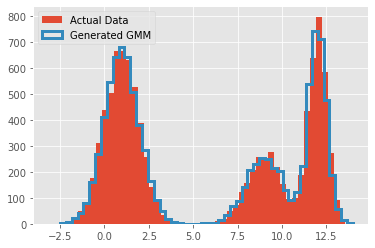

In [480]:
data = gmm_data_creation(mus=[1, 9, 12], rates=[0.5, 0.2, 0.3], sigmas=[1, 1, 0.5], n_samples=10000)
params = gmm_em(data)

plt.hist(data, label="Actual Data", bins=50)
generated = gmm_data_creation(params[0], params[1], params[2], n_samples=10000)
plt.hist(generated, label="Generated GMM", histtype="step", bins=50, linewidth=3)
plt.legend()
plt.show()

In [481]:
params

([0.9918258082100696, 9.015587326901198, 11.999630931465406],
 [0.49999736373515863, 0.20131719967656933, 0.298685436588272],
 [0.9861854575959232, 1.0158791191549275, 0.4982628035909606])